In [1]:
#MSDS 457: Sports Management Analytics
#Final Project: Team Evaluation and Relocation Assessment - Tampa Bay Rays
#Authors: Walsh, Conor and Holsey, Patrick

In [2]:
import pandas as pd
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import os
from functools import reduce

In [3]:
#change working directory
import os

os.chdir("C:\\Users\\holse\OneDrive\\Documents\\Northwestern\\MSDS 457 - Sports Management Analytics\\Final Project")

<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\O'
C:\Users\holse\AppData\Local\Temp\ipykernel_44760\81633094.py:4: SyntaxWarning: invalid escape sequence '\O'
  os.chdir("C:\\Users\\holse\OneDrive\\Documents\\Northwestern\\MSDS 457 - Sports Management Analytics\\Final Project")


In [4]:
##Data Imports
salaries_raw = pd.read_csv("2024_Salaries.csv", encoding = "ISO-8859-1")
win_pct_data = pd.read_csv("2024_WL_Records.csv", encoding = "ISO-8859-1")
TB_batting = pd.read_csv("TB_performance_batters.csv")
TB_SP = pd.read_csv("TB_performance_SP.csv")
TB_RP = pd.read_csv("TB_performance_RP.csv")
League_C = pd.read_csv("C_performance.csv")
League_1B = pd.read_csv("1B_performance.csv")
League_2B = pd.read_csv("2B_performance.csv")
League_SS = pd.read_csv("SS_performance.csv")
League_3B = pd.read_csv("3B_performance.csv")
League_OF = pd.read_csv("OF_performance.csv")
League_DH = pd.read_csv("DH_performance.csv")
League_SP = pd.read_csv("SP_performance.csv")
League_RP = pd.read_csv("RP_performance.csv")
Rays_2024 = pd.read_excel("Rays_game_attendance_promos_2024.xlsx")
Rays_2023 = pd.read_excel("Rays_game_attendance_promos_2023.xlsx")
Rays_2022 = pd.read_excel("Rays_game_attendance_promos_2022.xlsx")
MLB_attendance = pd.read_excel("MLB_attendance_by_year.xlsx")
Rays_rev = pd.read_excel("Rays_revenue_tickets_est.xlsx")

# Import for Training Classifiers
tv_rank_data = pd.read_excel("TV_market_rank.xlsx")
metro_data = pd.read_excel("Metro_area_population.xlsx")
income_data = pd.read_excel("Per_capita_income_2022.xlsx")
fortune1000_data = pd.read_excel("Fortune_1000_companies.xlsx")
dis2park_data = pd.read_excel("Distance_to_MLB_team.xlsx")


In [5]:
income_data = income_data.iloc[:,[0,2,3,4,5]] #Remove fields I don't need
dis2park_data = dis2park_data.iloc[:,[0,1]]

In [6]:
salary_data = pd.DataFrame(salaries_raw)

Names = [] #Create lists from salary data
Team = []
Pos = []
Salary = []

for i in range(0, len(salary_data)):
    if "$" in str(salary_data.loc[i]):
        Names.append(salary_data.loc[i-2].str.split(',')[0][0])
        Team.append(salary_data.loc[i-1].str.split(',')[0][0])
        Pos.append(salary_data.loc[i-1].str.split(',')[0][1])
        currency_str = salary_data.loc[i].str.split('.')[0][0]
        cleaned_str = currency_str.replace("$", "").replace(",", "").replace(" ", "")
        Salary.append(float(Decimal(cleaned_str)))

for i in range(0, len(Team)):
    Team[i] = Team[i].replace(u'\xa0',u'')


C:\Users\holse\AppData\Local\Temp\ipykernel_44760\516546612.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Names.append(salary_data.loc[i-2].str.split(',')[0][0])
C:\Users\holse\AppData\Local\Temp\ipykernel_44760\516546612.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Team.append(salary_data.loc[i-1].str.split(',')[0][0])
C:\Users\holse\AppData\Local\Temp\ipykernel_44760\516546612.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

In [7]:
Full_List = pd.DataFrame(
  {'Name': Names,
   'Team': Team,
   'Position': Pos,
   'Salary' : Salary #in dollars
   }  
)

def format_currency(x):
    return '${:,.2f}'.format(x)

#Full_List['Salary'] = (Full_List['Salary']/1e6).round(2)
Full_List[Full_List['Team']== 'TB']

,Name,Team,Position,Salary
174,Brandon Lowe,TB,2B,8750000.0
189,Yandy Diaz,TB,1B,8000000.0
249,Jeffrey Springs,TB,SP,5250000.0
292,Pete Fairbanks,TB,RP,3666667.0
295,Shane McClanahan,TB,SP/SP1,3600000.0
354,Wander Franco,TB,SS,2454545.0
358,Colin Poche,TB,RP/SU7,2375000.0
359,Dylan Carlson,TB,LF,2350000.0
391,Tyler Alexander,TB,RP,1950000.0
396,Drew Rasmussen,TB,RP,1862500.0


In [8]:
def Get_Team_Ledger(
        team_names: list[str],
        data: pd.DataFrame
):

    """ 
    Will return total salary for team input 
    """
    data_result = pd.DataFrame(columns=['Team','Payroll'])
    data_result['Team'] = team_names
    salaries = []
    for team in team_names:
        curr_data = data[data['Team']== team]
        salaries.append(sum(curr_data["Salary"].values)/1000000)
    data_result['Payroll']= salaries
    data_result = data_result.sort_values(by='Payroll', ascending= False)
    
    return data_result.reset_index(drop=True)

def Calc_HHI(
        team_names: list[str],
        data: pd.DataFrame
):
    HHI_df = pd.DataFrame(columns=['Team','HHI'])
    HHI_df['Team'] = team_names
    HHI_teams = []
    for team in team_names:
        curr_data = data[data['Team'] == team]
        curr_data = curr_data.reset_index(drop=True)
        total_sal = sum(curr_data["Salary"].values)
        temp_list = []
        for i in range (0, len(curr_data)):
            HHI_player = (curr_data['Salary'][i]/total_sal)**2
            temp_list.append(HHI_player)
        HHI_team = sum(temp_list)
        HHI_teams.append(HHI_team)
    HHI_df['HHI'] = HHI_teams

    HHI_df = HHI_df.sort_values(by='HHI', ascending= False)
    
    return HHI_df.reset_index(drop=True)

def Calc_Rel_Salary(
        team_names: list[str],
        data: pd.DataFrame
):
    Rel_sals = []
    team_ledger = Get_Team_Ledger(team_names, data)
    Relative_Salaries = pd.DataFrame(columns=['Team','Rel_Salary_Score'])
    
    Relative_Salaries['Team'] = team_names
    avg_sal = np.average(team_ledger['Payroll'].values)
    
    for team in team_names:
        salary_temp = team_ledger[team_ledger['Team'] == team]
        rel_sal = sum(salary_temp['Payroll'].values/avg_sal)*100
        Rel_sals.append(rel_sal)
    Relative_Salaries['Rel_Salary_Score'] = Rel_sals

    Relative_Salaries = Relative_Salaries.sort_values(by='Rel_Salary_Score', ascending= False)
    
    return Relative_Salaries.reset_index(drop=True)


In [9]:
Realtive_Salaries = Calc_Rel_Salary(Full_List['Team'].unique().tolist(), Full_List)


In [10]:
Team_Costs = Get_Team_Ledger(Full_List['Team'].unique().tolist(), Full_List)


In [11]:
hhi_df= Calc_HHI(Full_List['Team'].unique().tolist(),Full_List)

In [12]:
temp_df = Team_Costs.merge(win_pct_data, on='Team', how ='inner')
next_temp = temp_df.merge(Realtive_Salaries, on='Team', how= 'inner')
all_df = next_temp.merge(hhi_df, on='Team', how ='inner') #Merge HHI, Win Pct and Rel Sal dfs
all_df = all_df.sort_values(by='Winning_Percentage', ascending= False)

columns_to_normalize = ['Payroll','Rel_Salary_Score','HHI']
scaler = MinMaxScaler()
all_df[columns_to_normalize] = scaler.fit_transform(all_df[columns_to_normalize])


In [13]:
all_df_test = all_df[all_df['Team'].isin(['NYM','ARI','DET','SEA'])]
all_df_train = all_df[~all_df['Team'].isin(['NYM','ARI','DET','SEA'])]
all_df_test.reset_index(inplace=True,drop=True)
all_df_train.reset_index(inplace=True, drop=True)

In [14]:
#TB hitter performance
TB_batting = TB_batting[['Name', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA']]
TB_batting = TB_batting.sort_values(by='wRAA', ascending=False)

# Function to highlight the column
def highlight_column(s):
    return ['background-color: yellow' if s.name == 'wRAA' else '' for _ in s]

# Apply highlighting to the column
TB_batting_upd = TB_batting.style.apply(highlight_column, axis=0)\
    .set_properties(subset=['wRAA'], **{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})


TB_batting_upd

,Name,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA
5,Isaac Paredes,429,16,41,55,0,0.245179,0.121212,0.158508,0.259786,0.791905,0.346716,12.615614
14,Yandy Díaz,621,14,55,65,0,0.280639,0.080515,0.152979,0.314410,0.755239,0.330533,10.173440
2,Brandon Lowe,425,21,56,58,5,0.244156,0.077647,0.263529,0.287402,0.783316,0.334698,8.387121
0,Amed Rosario,275,2,22,26,9,0.306818,0.025455,0.174545,0.367442,0.747576,0.324363,3.139530
11,Randy Arozarena,409,15,45,37,16,0.211429,0.110024,0.246944,0.248945,0.712134,0.314866,1.542783
10,Junior Caminero,177,6,15,18,2,0.248485,0.062147,0.214689,0.289256,0.723677,0.309387,-0.112835
12,Richie Palacios,316,5,46,21,19,0.223485,0.142405,0.212025,0.279793,0.664214,0.302825,-1.870505
9,Josh Lowe,387,10,37,34,25,0.240793,0.082687,0.317829,0.337838,0.693260,0.298743,-3.562217
4,Harold Ramírez,169,1,21,13,5,0.268293,0.017751,0.195266,0.328244,0.588902,0.259580,-6.882602
1,Ben Rortvedt,328,3,27,31,1,0.227586,0.103659,0.268293,0.316583,0.620521,0.283090,-7.151466


In [15]:
#TB starting pitcher performance
TB_SP = TB_SP[['Name', 'W', 'L', 'GS', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'ERA']]
TB_SP = TB_SP.sort_values(by='ERA', ascending=True)

# Function to highlight the column
def highlight_column(s):
    return ['background-color: yellow' if s.name == 'ERA' else '' for _ in s]

# Apply highlighting to the column
TB_SP_upd = TB_SP.style.apply(highlight_column, axis=0)\
    .set_properties(subset=['ERA'], **{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

TB_SP_upd

,Name,W,L,GS,IP,K/9,BB/9,HR/9,BABIP,ERA
0,Shane Baz,4,3,14,79.100000,7.827732,3.063025,1.021008,0.228571,3.063025
1,Jeffrey Springs,2,2,7,33.000000,10.090909,3.000000,1.363636,0.329545,3.272727
2,Ryan Pepiot,8,8,26,130.000000,9.830769,3.323077,1.176923,0.261538,3.600000
3,Zack Littell,8,10,29,156.100000,8.117271,1.784648,1.266525,0.310722,3.626866
4,Zach Eflin,5,7,19,110.000000,7.118182,1.063636,1.145455,0.294461,4.090909
5,Taj Bradley,8,11,25,138.000000,10.043478,3.065217,1.434783,0.284091,4.108696
6,Tyler Alexander,1,2,9,45.200000,7.489052,2.167883,1.576642,0.255814,4.138686
7,Aaron Civale,2,6,17,87.000000,8.689656,2.793104,1.655173,0.311741,5.068966


In [16]:
#TB relief pitcher performance
TB_RP = TB_RP[['Name', 'W', 'L', 'SV', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'ERA']]
TB_RP = TB_RP.sort_values(by='ERA', ascending=True)

# Function to highlight the column
def highlight_column(s):
    return ['background-color: yellow' if s.name == 'ERA' else '' for _ in s]

# Apply highlighting to the column
TB_RP_upd = TB_RP.style.apply(highlight_column, axis=0)\
    .set_properties(subset=['ERA'], **{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

TB_RP_upd

,Name,W,L,SV,IP,K/9,BB/9,HR/9,BABIP,ERA
0,Edwin Uceta,2,0,5,41.200000,12.312002,1.728000,0.432000,0.263736,1.512000
1,Manuel Rodríguez,3,4,2,37.200000,8.123895,2.628319,0.716814,0.247619,2.150443
2,Jason Adam,4,2,4,47.000000,9.574469,3.063830,0.765958,0.205607,2.489362
3,Kevin Kelly,5,2,1,70.200000,8.023587,1.146227,0.891510,0.268041,2.674529
4,Pete Fairbanks,3,3,23,45.100000,8.735294,3.375000,0.794118,0.266667,3.573530
5,Garrett Cleavinger,7,5,6,60.000000,10.650002,4.650001,0.900000,0.304636,3.750001
6,Colin Poche,1,2,2,37.100000,7.955358,3.133929,1.687500,0.230000,3.857143
7,Phil Maton,1,2,2,35.100000,7.641511,4.584906,1.528302,0.247312,4.584906
8,Tyler Alexander,5,3,0,62.000000,7.548388,1.887097,2.177419,0.293478,5.806452
9,Shawn Armstrong,2,1,1,34.200000,8.567308,4.153846,1.298077,0.361111,6.490385


In [38]:
pd.set_option('display.max_rows', None)

#Join player performance and salaries lists
League_C_joined = League_C.merge(Full_List, how='cross')
League_1B_joined = League_1B.merge(Full_List, how='cross')
League_2B_joined = League_2B.merge(Full_List, how='cross')
League_SS_joined = League_SS.merge(Full_List, how='cross')
League_3B_joined = League_3B.merge(Full_List, how='cross')
League_OF_joined = League_OF.merge(Full_List, how='cross')
League_DH_joined = League_DH.merge(Full_List, how='cross')
League_SP_joined = League_SP.merge(Full_List, how='cross')
League_RP_joined = League_RP.merge(Full_List, how='cross')

#Filter joined list where name matches
League_C_joined = League_C_joined.query("Name_x == Name_y")
League_1B_joined = League_1B_joined.query("Name_x == Name_y")
League_2B_joined = League_2B_joined.query("Name_x == Name_y")
League_SS_joined = League_SS_joined.query("Name_x == Name_y")
League_3B_joined = League_3B_joined.query("Name_x == Name_y")
League_OF_joined = League_OF_joined.query("Name_x == Name_y")
League_DH_joined = League_DH_joined.query("Name_x == Name_y")
League_SP_joined = League_SP_joined.query("Name_x == Name_y")
League_RP_joined = League_RP_joined.query("Name_x == Name_y")

#Remove unnecessary columns from joined dataframes
League_C_joined = League_C_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_1B_joined = League_1B_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_2B_joined = League_2B_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_SS_joined = League_SS_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_3B_joined = League_3B_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_OF_joined = League_OF_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA', 'Salary']]
League_DH_joined = League_DH_joined[['Name_x', 'Team_x', 'PA', 'HR', 'R', 'RBI', 'SB', 'AVG', 'BB%', 'K%', 'BABIP', 'OPS', 'wOBA', 'wRAA','Salary']]
League_SP_joined = League_SP_joined[['Name_x', 'Team_x', 'W', 'L', 'GS', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'ERA', 'Salary']]
League_RP_joined = League_RP_joined[['Name_x', 'Team_x', 'W', 'L', 'SV', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'ERA', 'Salary']]


#Dropping duplicate names Luis Garcia SP, Luis Garcia RP, Will Smith C and Will Smith RP.
League_C_joined = League_C_joined.drop([58505])
League_RP_joined = League_RP_joined.drop([99657, 99663, 271988])



#Reformatting Salary column 
def format_currency(x):
    return '${:,.2f}'.format(x)

Full_List_upd = Full_List.style.format({'Salary': format_currency})
Full_List_upd

,Name,Team,Position,Salary
0,Shohei Ohtani,LAD,DH,"$70,000,000.00"
1,Max Scherzer,TEX,SP,"$43,333,334.00"
2,Justin Verlander,HOU,SP,"$43,333,333.00"
3,Aaron Judge,NYY,CF,"$40,000,000.00"
4,Jacob deGrom,TEX,SP,"$40,000,000.00"
5,Anthony Rendon,LAA,3B,"$38,571,428.00"
6,Mike Trout,LAA,CF,"$37,116,666.00"
7,Gerrit Cole,NYY,SP,"$36,000,000.00"
8,Patrick Corbin,WSH,SP,"$35,416,670.00"
9,Corey Seager,TEX,SS,"$35,000,000.00"


In [40]:
#League catcher performance comparison
League_C_joined = League_C_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_C_upd = League_C_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_C_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
24855,J.T. Realmuto,PHI,413,14,50,47,2,0.265789,0.065375,0.246973,0.328302,0.750981,0.326066,5.280929,"$23,875,000.00"
50771,Salvador Perez,KCR,652,27,58,104,0,0.271186,0.067485,0.197853,0.302273,0.786193,0.335024,13.037772,"$20,000,000.00"
60492,Willson Contreras,STL,358,15,48,36,4,0.262458,0.125698,0.268156,0.336842,0.848327,0.370183,17.289484,"$18,000,000.00"
58346,Will Smith,LAD,544,20,77,75,1,0.247899,0.093750,0.193015,0.272981,0.759979,0.325752,6.818482,"$16,550,000.00"
28174,James McCann,BAL,233,8,27,31,1,0.233645,0.055794,0.240343,0.272727,0.666820,0.288337,-4.096159,"$12,150,000.00"
10944,Christian Vazquez,MIN,315,7,29,27,3,0.221088,0.034921,0.206349,0.256637,0.574918,0.250047,-15.245413,"$10,000,000.00"
51965,Sean Murphy,ATL,264,10,19,25,0,0.193133,0.102273,0.253788,0.222930,0.636022,0.281391,-6.116975,"$9,000,000.00"
55217,Travis d'Arnaud,ATL,341,15,40,48,1,0.237785,0.070381,0.260997,0.280193,0.738535,0.318790,2.363381,"$8,000,000.00"
33670,Keibert Ruiz,WSN,485,13,46,57,3,0.228758,0.032990,0.111340,0.231738,0.619271,0.268488,-16.274291,"$6,375,000.00"
57416,Victor Caratini,HOU,274,8,30,30,0,0.269388,0.083942,0.193431,0.310160,0.743930,0.324350,3.125218,"$6,000,000.00"


In [42]:
#League 1B performance comparison
League_1B_joined = League_1B_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_1B_upd = League_1B_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_1B_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
34548,Kris Bryant,COL,155,2,9,15,0,0.218045,0.083871,0.309677,0.321429,0.623333,0.287028,-2.888185,"$28,000,000.00"
4338,Bryce Harper,PHI,631,30,85,87,7,0.285455,0.120444,0.218700,0.330729,0.898470,0.380217,35.569989,"$27,538,462.00"
14052,Freddie Freeman,LAD,638,22,81,89,9,0.282288,0.122257,0.156740,0.306075,0.853758,0.365357,28.333984,"$27,000,000.00"
46426,Paul Goldschmidt,STL,654,22,70,65,11,0.245409,0.071865,0.264526,0.307882,0.715562,0.309823,-0.187654,"$26,000,000.00"
39968,Matt Olson,ATL,685,29,78,98,0,0.246667,0.103650,0.248175,0.293103,0.789513,0.339450,16.137982,"$22,000,000.00"
48606,Pete Alonso,NYM,695,34,91,88,3,0.240132,0.100719,0.247482,0.275862,0.788378,0.339853,16.598852,"$20,500,000.00"
55087,Salvador Perez,KCR,652,27,58,104,0,0.271186,0.067485,0.197853,0.302273,0.786193,0.335024,13.037772,"$20,000,000.00"
65878,Vladimir Guerrero Jr.,TOR,697,30,98,103,2,0.323052,0.103300,0.137733,0.342105,0.939814,0.397890,49.204889,"$19,900,000.00"
2233,Anthony Rizzo,NYY,375,8,38,35,0,0.228487,0.072000,0.173333,0.259398,0.636645,0.284789,-7.663185,"$17,000,000.00"
29214,Josh Bell,- - -,603,19,62,71,0,0.249071,0.084577,0.199005,0.286070,0.724602,0.316761,3.281083,"$16,500,000.00"


In [44]:
#League 2B performance comparison
League_2B_joined = League_2B_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_2B_upd = League_2B_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_2B_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
35622,Jose Altuve,HOU,682,20,94,65,22,0.294586,0.068915,0.174487,0.337423,0.789930,0.344238,18.695197,"$31,500,000.00"
46425,Marcus Semien,TEX,718,23,101,74,8,0.236923,0.089136,0.146240,0.250478,0.698569,0.305883,-2.482757,"$26,000,000.00"
64770,Xander Bogaerts,SDP,463,11,50,44,13,0.264019,0.060475,0.170626,0.296512,0.687537,0.299774,-3.877501,"$25,454,545.00"
23838,Gleyber Torres,NYY,665,15,80,63,4,0.257240,0.097744,0.204511,0.306306,0.708511,0.312673,1.334693,"$14,200,000.00"
37871,Ketel Marte,ARI,583,36,93,95,7,0.291667,0.111492,0.181818,0.299191,0.931737,0.391000,37.923694,"$13,600,000.00"
51927,Nico Hoerner,CHC,641,7,86,48,31,0.273196,0.068643,0.102964,0.296875,0.708266,0.313119,1.516770,"$11,500,000.00"
42223,Luis Arraez,- - -,672,4,83,46,9,0.313972,0.035714,0.043155,0.323967,0.738733,0.322787,6.819861,"$10,600,000.00"
34675,Jorge Polanco,SEA,469,16,43,45,4,0.213429,0.098081,0.292111,0.274436,0.651291,0.287065,-8.725206,"$10,500,000.00"
30363,Jeff McNeil,NYM,472,12,57,44,5,0.238208,0.074153,0.144068,0.256484,0.692290,0.303555,-2.516415,"$10,250,000.00"
6648,Brandon Lowe,TBR,425,21,56,58,5,0.244156,0.077647,0.263529,0.287402,0.783316,0.334698,8.387121,"$8,750,000.00"


In [46]:
#League SS performance comparison
League_SS_joined = League_SS_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_SS_upd = League_SS_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_SS_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
11878,Corey Seager,TEX,533,30,68,74,1,0.277895,0.099437,0.180113,0.290598,0.864299,0.364663,23.373306,"$35,000,000.00"
22671,Francisco Lindor,NYM,689,33,107,91,29,0.273463,0.081277,0.184325,0.295011,0.843977,0.362886,29.228473,"$34,100,000.00"
7566,Carlos Correa,MIN,367,14,55,54,0,0.310345,0.108992,0.166213,0.342742,0.905220,0.385305,22.190938,"$33,333,333.00"
39941,Mookie Betts,LAD,516,19,75,75,16,0.288889,0.118217,0.110465,0.293651,0.863204,0.370969,25.246530,"$30,000,000.00"
50737,Trea Turner,PHI,539,21,88,62,19,0.295050,0.050093,0.181818,0.330749,0.806969,0.349067,16.870165,"$27,272,727.00"
14054,Dansby Swanson,CHC,593,16,82,66,19,0.241573,0.091062,0.242833,0.299735,0.701486,0.306569,-1.722820,"$26,000,000.00"
30243,Javier Báez,DET,289,6,25,37,8,0.183824,0.041522,0.238754,0.220000,0.515571,0.224259,-19.985411,"$25,000,000.00"
51835,Trevor Story,BOS,106,2,8,10,6,0.255319,0.103774,0.311321,0.372881,0.733240,0.317581,0.631458,"$22,500,000.00"
57306,Willy Adames,MIL,688,32,93,112,21,0.250820,0.107558,0.251453,0.296569,0.793690,0.341932,17.582900,"$12,250,000.00"
1201,Bo Bichette,TOR,336,4,29,31,5,0.225080,0.059524,0.190476,0.269388,0.598329,0.263634,-12.587336,"$12,083,333.00"


In [48]:
#League 3B performance comparison
League_3B_joined = League_3B_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_3B_upd = League_3B_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_3B_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
5400,Anthony Rendon,LAA,238,0,21,14,6,0.218447,0.096639,0.147059,0.257143,0.573713,0.264098,-8.827156,"$38,571,428.00"
57197,Nolan Arenado,STL,635,16,70,71,2,0.271626,0.069291,0.144882,0.295597,0.719385,0.313659,1.778443,"$35,000,000.00"
3254,Alex Bregman,HOU,634,26,79,75,3,0.259897,0.069401,0.135647,0.264271,0.768125,0.330704,10.473608,"$30,500,000.00"
62601,Rafael Devers,BOS,601,28,87,83,3,0.272381,0.111481,0.244592,0.323034,0.870600,0.364028,26.047791,"$29,318,181.00"
6520,Austin Riley,ATL,469,19,63,56,0,0.256471,0.078891,0.251599,0.310345,0.783138,0.337959,10.486455,"$21,000,000.00"
47550,Manny Machado,SDP,643,29,77,105,11,0.274874,0.069984,0.192846,0.301802,0.797214,0.339665,15.259482,"$17,090,909.00"
35684,José Ramírez,CLE,682,39,114,118,41,0.279032,0.079179,0.120235,0.265347,0.871899,0.364276,29.694765,"$17,000,000.00"
49713,Matt Chapman,SFG,647,27,98,78,15,0.246957,0.098918,0.244204,0.293367,0.790275,0.340136,15.599799,"$16,666,666.00"
30303,Jeimer Candelario,CIN,463,20,47,56,4,0.224824,0.058315,0.246220,0.256757,0.707189,0.303528,-2.478389,"$15,000,000.00"
65948,Ryan McMahon,COL,645,20,68,65,4,0.241623,0.106977,0.286822,0.319672,0.721864,0.315404,2.712358,"$12,000,000.00"


In [50]:
#League OF performance comparison
League_OF_joined = League_OF_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_OF_upd = League_OF_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_OF_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
8635,Aaron Judge,NYY,704,58,122,144,10,0.322004,0.188920,0.242898,0.367470,1.159289,0.475734,93.807033,"$40,000,000.00"
74467,Juan Soto,NYY,713,41,128,109,7,0.288194,0.180926,0.166900,0.297619,0.988799,0.420585,63.358094,"$31,000,000.00"
105760,Mookie Betts,LAD,516,19,75,75,16,0.288889,0.118217,0.110465,0.293651,0.863204,0.370969,25.246530,"$30,000,000.00"
34551,Cody Bellinger,CHC,569,18,72,78,9,0.265504,0.079086,0.156415,0.287440,0.751488,0.321818,5.330162,"$27,500,000.00"
33475,Christian Yelich,MIL,315,11,44,42,21,0.314815,0.126984,0.184127,0.366337,0.909455,0.391380,20.587085,"$26,000,000.00"
46432,George Springer,TOR,614,19,74,56,16,0.220183,0.097720,0.187296,0.244552,0.674068,0.298321,-5.859919,"$24,166,666.00"
124125,Teoscar Hernandez,LAD,652,33,84,99,12,0.271647,0.081288,0.288344,0.344173,0.840327,0.359840,26.060611,"$23,500,000.00"
50760,Ian Happ,CHC,657,25,89,86,13,0.242531,0.121766,0.255708,0.298942,0.782068,0.341045,16.321662,"$21,000,000.00"
117659,Seiya Suzuki,CHC,585,21,74,73,16,0.283203,0.107692,0.273504,0.370149,0.848234,0.364873,25.752209,"$21,000,000.00"
120897,Starling Marte,NYM,370,7,46,40,16,0.268657,0.072973,0.218919,0.333333,0.715035,0.313053,0.855853,"$20,750,000.00"


In [52]:
#League DH performance comparison
League_DH_joined = League_DH_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_DH_upd = League_DH_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_DH_upd

,Name_x,Team_x,PA,HR,R,RBI,SB,AVG,BB%,K%,BABIP,OPS,wOBA,wRAA,Salary
0,Shohei Ohtani,LAD,731,54,134,130,59,0.309748,0.110807,0.221614,0.336471,1.036336,0.430549,70.820188,"$70,000,000.00"
6477,Aaron Judge,NYY,187,10,28,34,0,0.326667,0.171123,0.251337,0.419355,1.043656,0.439087,19.401755,"$40,000,000.00"
15120,Giancarlo Stanton,NYY,454,27,49,68,0,0.230583,0.083700,0.312775,0.277551,0.768231,0.327996,6.510401,"$32,000,000.00"
14050,Cody Bellinger,CHC,107,6,15,14,1,0.323232,0.056075,0.140187,0.325000,0.920797,0.385889,6.520127,"$27,500,000.00"
22685,Christian Yelich,MIL,115,2,15,14,8,0.295918,0.121739,0.226087,0.380282,0.783924,0.348810,3.575668,"$26,000,000.00"
7601,Seiya Suzuki,CHC,262,8,32,27,10,0.298246,0.122137,0.293893,0.416667,0.846022,0.368691,12.338603,"$21,000,000.00"
5449,Kyle Schwarber,PHI,670,37,106,100,4,0.241441,0.153731,0.285075,0.289552,0.837179,0.360242,26.996603,"$20,000,000.00"
21639,Vladimir Guerrero Jr.,TOR,128,6,12,19,0,0.263158,0.093750,0.140625,0.263736,0.827166,0.346904,3.783462,"$19,900,000.00"
17326,Masataka Yoshida,BOS,410,9,43,54,2,0.278378,0.065854,0.126829,0.302251,0.746605,0.329117,6.249346,"$18,600,000.00"
29201,Willson Contreras,STL,141,4,16,10,1,0.223140,0.113475,0.283688,0.298701,0.721763,0.321748,1.312958,"$18,000,000.00"


In [54]:
#League SP performance comparison
League_SP_joined = League_SP_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_SP_upd = League_SP_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_SP_upd

,Name_x,Team_x,W,L,GS,IP,K/9,BB/9,HR/9,BABIP,ERA,Salary
98190,Max Scherzer,TEX,2,4,9,43.100000,8.307693,2.076923,1.453846,0.277311,3.946154,"$43,333,334.00"
196380,Justin Verlander,HOU,5,6,17,90.100000,7.372694,2.690037,1.494465,0.302920,5.479705,"$43,333,333.00"
49641,Gerrit Cole,NYY,8,5,17,95.000000,9.378947,2.747368,1.042105,0.273469,3.410526,"$36,000,000.00"
198544,Patrick Corbin,WSN,6,13,32,174.200000,7.162214,2.782443,1.288168,0.337017,5.616413,"$35,416,670.00"
99289,Carlos Rodon,NYY,16,9,32,175.000000,10.028571,2.931429,1.594286,0.284424,3.960000,"$27,833,333.00"
216911,Jordan Montgomery,ARI,8,7,21,104.000000,6.663462,3.461538,1.125000,0.354651,6.403846,"$25,000,000.00"
64774,Aaron Nola,PHI,14,8,33,199.100000,8.894649,2.257525,1.354515,0.294444,3.566890,"$24,571,428.00"
73408,Luis Castillo,SEA,11,12,30,175.100000,8.982890,2.412548,1.283270,0.284797,3.644487,"$24,150,000.00"
87436,Kevin Gausman,TOR,14,11,31,181.000000,8.055249,2.784530,0.994475,0.281008,3.828729,"$24,000,000.00"
7594,Zack Wheeler,PHI,16,7,32,200.000000,10.080000,2.340000,0.900000,0.246377,2.565000,"$23,500,000.00"


In [56]:
#League RP performance comparison
League_RP_joined = League_RP_joined.sort_values(by='Salary', ascending=False)

# Function to highlight the column
def highlight_rows(row):
    return ['background-color: yellow' if row['Team_x'] == 'TBR' else '' for _ in row]

#Applying highlight to TB row and currency format for salary
League_RP_upd = League_RP_joined.style.apply(highlight_rows, axis=1)\
    .format({'Salary': '${:,.2f}'})\
    .set_properties(**{
        'color': 'blue',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
})

League_RP_upd

,Name_x,Team_x,W,L,SV,IP,K/9,BB/9,HR/9,BABIP,ERA,Salary
128461,Edwin Diaz,NYM,6,4,20,53.200000,14.086958,3.354038,1.173913,0.284314,3.521740,"$19,650,000.00"
154358,Josh Hader,HOU,8,8,34,71.000000,13.309861,3.169014,1.521127,0.229630,3.802817,"$19,000,000.00"
19508,Raisel Iglesias,ATL,6,2,34,69.100000,8.826924,1.687500,0.519231,0.198830,1.947116,"$16,000,000.00"
98273,Kenley Jansen,BOS,4,2,27,54.200000,10.207318,3.292683,0.658537,0.259542,3.292683,"$16,000,000.00"
9815,Nick Martinez,CIN,5,2,0,53.100000,7.762501,1.012500,0.675000,0.243243,1.856250,"$14,000,000.00"
118795,Ryan Pressly,HOU,2,3,4,56.200000,9.211766,2.858824,0.635294,0.333333,3.494118,"$14,000,000.00"
163032,Kenta Maeda,DET,1,1,0,42.000000,8.785715,1.500000,1.285714,0.278261,3.857143,"$14,000,000.00"
56221,Robert Suarez,SDP,9,3,36,65.000000,8.169232,2.215385,0.969231,0.255682,2.769231,"$13,000,000.00"
38974,Taylor Rogers,SFG,1,4,0,60.000000,9.600002,3.300001,1.050000,0.298701,2.400000,"$12,000,000.00"
161995,Drew Smyly,CHC,4,8,0,58.200000,8.590911,3.835228,1.534091,0.288344,3.835228,"$10,500,000.00"


In [58]:
#Filtering Rays and MLB attendance for relevant variables
Rays_2024 = Rays_2024[['Day', 'Opp', 'W', 'L', 'Attendance', 'Promotion', 'Kids']]
Rays_2023 = Rays_2023[['Day', 'Opp', 'W', 'L', 'Attendance', 'Promotion', 'Kids']]
Rays_2022 = Rays_2022[['Day', 'Opp', 'W', 'L', 'Attendance', 'Promotion', 'Kids']]
MLB_attendance = MLB_attendance[['Year', 'Time', 'Attendance', 'Attend/G', 'Payroll/Tm*']]

#Removing MLB attendance rows before year 2022
MLB_attendance = MLB_attendance.iloc[:3]

#Rounding MLB attendance/game to 0 decimals
MLB_attendance['Attend/G'] = MLB_attendance['Attend/G'].round(0).astype(int)

In [60]:
#Computing rounded mean of Rays attendance by year, adding column to MLB attendance df
MLB_attendance['Rays_attend'] = 0
MLB_attendance.loc[0, 'Rays_attend'] = round(Rays_2024['Attendance'].mean(), 0)
MLB_attendance.loc[1, 'Rays_attend'] = round(Rays_2023['Attendance'].mean(), 0)
MLB_attendance.loc[2, 'Rays_attend'] = round(Rays_2022['Attendance'].mean(), 0)

print(MLB_attendance)

   Year      Time  Attendance  Attend/G  Payroll/Tm*  Rays_attend
0  2024  02:38:00  71348366.0     29373  170108434.0        16515
1  2023  02:42:00  70747365.0     29114  154941212.0        17781
2  2022  03:06:00  64556658.0     26566  134486564.0        13927


           Day  Opp   W   L  Attendance                                          Promotion Kids
81      Sunday  NYY  28   7       32142                                   Devil Rays Socks    x
82    Saturday  NYY  27   7       27078                                                NaN  NaN
84      Friday  ATL  57  34       25025                                                NaN  NaN
165     Sunday  NYY  74  58       25025                                                NaN  NaN
85    Saturday  ATL  57  35       25025                                                NaN  NaN
163   Saturday  NYY  27  19       25025                        Devil Rays Throwback Jersey  NaN
162     Friday  BAL   1   0       25025                      Opening Day - Schedule Magnet  NaN
71    Thursday  TOR   0   1       25025                 Opening Day - Rays Schedule Magnet  NaN
164     Sunday  NYY  28  19       25025                         Sweatshirt Drawstring Bags    x
88    Saturday  CLE  71  48       25025 

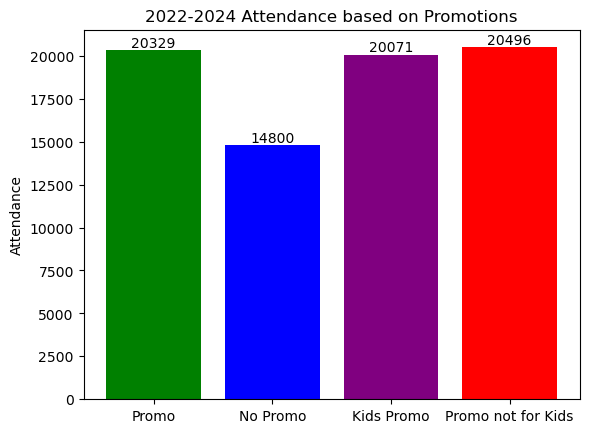

In [62]:
#Create a combined df
Rays_combined = pd.concat([Rays_2024, Rays_2023, Rays_2022], ignore_index=True)

#Sort and print combined df
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
Rays_combined_sorted = Rays_combined.sort_values(by="Attendance", ascending=False)
print(Rays_combined_sorted)

#Create a list of dfs
Rays_combined = [Rays_2024, Rays_2023, Rays_2022]

#Attendance 2022-2024 with Promotion
promo_games = [df[df['Promotion'].notna()] for df in Rays_combined]

#Combine the filtered dfs into one
promo_games_combined = pd.concat(promo_games, ignore_index=True)

#Calculate avg attendance 2022-2024 for games with Promotion
promo_games_result = math.floor(promo_games_combined['Attendance'].mean())

#Attendance 2022-2024 without Promotion
nopromo_games = [df[df['Promotion'].isna()] for df in Rays_combined]

#Combine the filtered dfs into one
nopromo_games_combined = pd.concat(nopromo_games, ignore_index=True)

#Calculate avg attendance 2022-2024 for games without a Promotion
nopromo_games_result = math.floor(nopromo_games_combined['Attendance'].mean())

#Attendance 2022-2024 with Kids Promotion
kidpromo_games = [df[df['Kids'].notna()] for df in Rays_combined]

#Combine the filtered dfs into one
kidpromo_games_combined = pd.concat(kidpromo_games, ignore_index=True)

#Calculate avg attendance 2022-2024 for games with a Promotion for Kids
kidpromo_games_result = math.floor(kidpromo_games_combined['Attendance'].mean())

#Attendance 2022-2024 with a Promotion not aimed for Kids
nokidpromo_games = [df[df['Promotion'].notna() & df['Kids'].isna()] for df in Rays_combined]

#Combine the filtered dfs into one
nokidpromo_games_combined = pd.concat(nokidpromo_games, ignore_index=True)

#Calculate avg attendance 2022-2024 for games with a Promotion not aimed for Kids
nokidpromo_games_result = math.floor(nokidpromo_games_combined['Attendance'].mean())

#Bar graph of Attendance with Promotion, without Promotion, Promotion for Kids, and Promotion not aimed for Kids
Attend_promo_cat = ['Promo', 'No Promo', 'Kids Promo', 'Promo not for Kids']
Attend_promo_total = [promo_games_result, nopromo_games_result, kidpromo_games_result, nokidpromo_games_result]
Promo_colors = ['green', 'blue', 'purple', 'red']

Attend_bar = plt.bar(Attend_promo_cat, Attend_promo_total, color=Promo_colors)
plt.ylabel('Attendance')
plt.title('2022-2024 Attendance based on Promotions')

for bar in Attend_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

#Attendance by Promotion 2024
promo_2024 = Rays_2024[Rays_2024['Promotion'].notna()]
print("")
print("The average attendance of a 2024 game with any Promotion is: ", math.floor(promo_2024['Attendance'].mean()))

#Attendance without Promotion 2024
nopromo_2024 = Rays_2024[Rays_2024['Promotion'].isna()]
print("The average attendance of a 2024 game without a Promotion is: ", math.floor(nopromo_2024['Attendance'].mean()))

#Attendance by Kids Promotion 2024
kidspromo_2024 = Rays_2024[Rays_2024['Kids'].notna()]
print("The average attendance of a 2024 game with a Kids Promotion is: ", math.floor(kidspromo_2024['Attendance'].mean()))

#Attendance by Promotion not aimed for Kids 2024
nokidpromo_2024 = Rays_2024[Rays_2024['Promotion'].notna() & Rays_2024['Kids'].isna()]
print("The average attendance of a 2024 game with a Promotion not aimed for Kids is: ", math.floor(nokidpromo_2024['Attendance'].mean()))

#Attendance by Promotion 2023
promo_2023 = Rays_2023[Rays_2023['Promotion'].notna()]
print("")
print("The average attendance of a 2023 game with any Promotion is: ", math.floor(promo_2023['Attendance'].mean()))

#Attendance without Promotion 2023
nopromo_2023 = Rays_2023[Rays_2023['Promotion'].isna()]
print("The average attendance of a 2023 game without a Promotion is: ", math.floor(nopromo_2023['Attendance'].mean()))

#Attendance by Kids Promotion 2023
kidspromo_2023 = Rays_2023[Rays_2023['Kids'].notna()]
print("The average attendance of a 2023 game with a Kids Promotion is: ", math.floor(kidspromo_2023['Attendance'].mean()))

#Attendance by Promotion not aimed for Kids 2023
nokidpromo_2023 = Rays_2023[Rays_2023['Promotion'].notna() & Rays_2023['Kids'].isna()]
print("The average attendance of a 2023 game with a Promotion not aimed for Kids is: ", math.floor(nokidpromo_2023['Attendance'].mean()))

#Attendance by Promotion 2022
promo_2022 = Rays_2022[Rays_2022['Promotion'].notna()]
print("")
print("The average attendance of a 2022 game with any Promotion is: ", math.floor(promo_2022['Attendance'].mean()))

#Attendance without Promotion 2022
nopromo_2022 = Rays_2022[Rays_2022['Promotion'].isna()]
print("The average attendance of a 2022 game without a Promotion is: ", math.floor(nopromo_2022['Attendance'].mean()))

#Attendance by Kids Promotion 2022
kidspromo_2022 = Rays_2022[Rays_2022['Kids'].notna()]
print("The average attendance of a 2022 game with a Kids Promotion is: ", math.floor(kidspromo_2022['Attendance'].mean()))

#Attendance by Promotion not aimed for Kids 2022
nokidpromo_2022 = Rays_2022[Rays_2022['Promotion'].notna() & Rays_2022['Kids'].isna()]
print("The average attendance of a 2022 game with a Promotion not aimed for Kids is: ", math.floor(nokidpromo_2022['Attendance'].mean()))

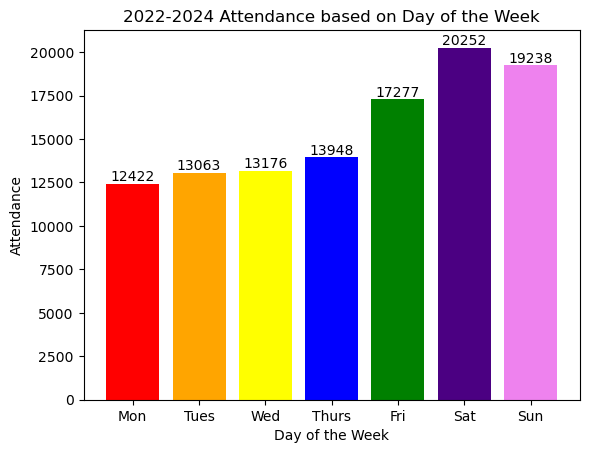

In [64]:
#Attendance by Day of the Week
#Filter rows where 'Day' equals 'Monday' for each df
Monday_attend = [df[df['Day'] == "Monday"] for df in Rays_combined]

# Combine the filtered dfs into one
Monday_attend_combined = pd.concat(Monday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Monday
Monday_avg = math.floor(Monday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Tuesday' for each df
Tuesday_attend = [df[df['Day'] == "Tuesday"] for df in Rays_combined]

#Combine the filtered dfs into one
Tuesday_attend_combined = pd.concat(Tuesday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Tuesday
Tuesday_avg = math.floor(Tuesday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Wednesday' for each df
Wednesday_attend = [df[df['Day'] == "Wednesday"] for df in Rays_combined]

#Combine the filtered dfs into one
Wednesday_attend_combined = pd.concat(Wednesday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Wednesday
Wednesday_avg = math.floor(Wednesday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Thursday' for each df
Thursday_attend = [df[df['Day'] == "Thursday"] for df in Rays_combined]

#Combine the filtered dfs into one
Thursday_attend_combined = pd.concat(Thursday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Thursday
Thursday_avg = math.floor(Thursday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Friday' for each df
Friday_attend = [df[df['Day'] == "Friday"] for df in Rays_combined]

#Combine the filtered dfs into one
Friday_attend_combined = pd.concat(Friday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Friday
Friday_avg = math.floor(Friday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Saturday' for each df
Saturday_attend = [df[df['Day'] == "Saturday"] for df in Rays_combined]

#Combine the filtered dfs into one
Saturday_attend_combined = pd.concat(Saturday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Saturday
Saturday_avg = math.floor(Saturday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Sunday' for each df
Sunday_attend = [df[df['Day'] == "Sunday"] for df in Rays_combined]

#Combine the filtered dfs into one
Sunday_attend_combined = pd.concat(Sunday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Sunday
Sunday_avg = math.floor(Sunday_attend_combined['Attendance'].mean())

#Bar graph for Attendance across Days of the Week
Attend_day_label = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
Attend_day_total = [Monday_avg, Tuesday_avg, Wednesday_avg, Thursday_avg, Friday_avg, Saturday_avg, Sunday_avg]
Day_colors = ['red', 'orange', 'yellow', 'blue', 'green', 'indigo', 'violet']

Day_bar = plt.bar(Attend_day_label, Attend_day_total, color=Day_colors)
plt.xlabel('Day of the Week')
plt.ylabel('Attendance')
plt.title('2022-2024 Attendance based on Day of the Week')

for bar in Day_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

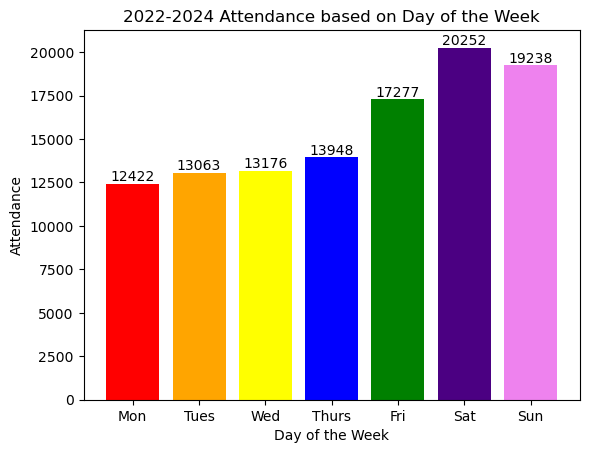

In [66]:
#Attendance by Day of the Week
#Filter rows where 'Day' equals 'Monday' for each df
Monday_attend = [df[df['Day'] == "Monday"] for df in Rays_combined]

# Combine the filtered dfs into one
Monday_attend_combined = pd.concat(Monday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Monday
Monday_avg = math.floor(Monday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Tuesday' for each df
Tuesday_attend = [df[df['Day'] == "Tuesday"] for df in Rays_combined]

#Combine the filtered dfs into one
Tuesday_attend_combined = pd.concat(Tuesday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Tuesday
Tuesday_avg = math.floor(Tuesday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Wednesday' for each df
Wednesday_attend = [df[df['Day'] == "Wednesday"] for df in Rays_combined]

#Combine the filtered dfs into one
Wednesday_attend_combined = pd.concat(Wednesday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Wednesday
Wednesday_avg = math.floor(Wednesday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Thursday' for each df
Thursday_attend = [df[df['Day'] == "Thursday"] for df in Rays_combined]

#Combine the filtered dfs into one
Thursday_attend_combined = pd.concat(Thursday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Thursday
Thursday_avg = math.floor(Thursday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Friday' for each df
Friday_attend = [df[df['Day'] == "Friday"] for df in Rays_combined]

#Combine the filtered dfs into one
Friday_attend_combined = pd.concat(Friday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Friday
Friday_avg = math.floor(Friday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Saturday' for each df
Saturday_attend = [df[df['Day'] == "Saturday"] for df in Rays_combined]

#Combine the filtered dfs into one
Saturday_attend_combined = pd.concat(Saturday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Saturday
Saturday_avg = math.floor(Saturday_attend_combined['Attendance'].mean())

#Filter rows where 'Day' equals 'Sunday' for each df
Sunday_attend = [df[df['Day'] == "Sunday"] for df in Rays_combined]

#Combine the filtered dfs into one
Sunday_attend_combined = pd.concat(Sunday_attend, ignore_index=True)

#Calculate avg attendance 2022-2024 for games on Sunday
Sunday_avg = math.floor(Sunday_attend_combined['Attendance'].mean())

#Bar graph for Attendance across Days of the Week
Attend_day_label = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
Attend_day_total = [Monday_avg, Tuesday_avg, Wednesday_avg, Thursday_avg, Friday_avg, Saturday_avg, Sunday_avg]
Day_colors = ['red', 'orange', 'yellow', 'blue', 'green', 'indigo', 'violet']

Day_bar = plt.bar(Attend_day_label, Attend_day_total, color=Day_colors)
plt.xlabel('Day of the Week')
plt.ylabel('Attendance')
plt.title('2022-2024 Attendance based on Day of the Week')

for bar in Day_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

In [68]:
#Attendance by Opponent
#Attendance for games vs Arizona Diamondbacks
opp_ARI = [df[df['Opp'] == "ARI"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_ARI_combined = pd.concat(opp_ARI, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> ARI
opp_ARI_mean = math.floor(opp_ARI_combined['Attendance'].mean())
print("The average attendance of a game vs Arizona Diamondbacks from 2022-2024 is: ", opp_ARI_mean)

#Attendance for games vs Atlanta Braves
opp_ATL = [df[df['Opp'] == "ATL"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_ATL_combined = pd.concat(opp_ATL, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> ATL
opp_ATL_mean = math.floor(opp_ATL_combined['Attendance'].mean())
print("The average attendance of a game vs Atlanta Braves from 2022-2024 is: ", opp_ATL_mean)

#Attendance for games vs Baltimore Orioles
opp_BAL = [df[df['Opp'] == "BAL"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_BAL_combined = pd.concat(opp_BAL, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> BAL
opp_BAL_mean = math.floor(opp_BAL_combined['Attendance'].mean())
print("The average attendance of a game vs Baltimore Orioles from 2022-2024 is: ", opp_BAL_mean)

#Attendance for games vs Boston Red Sox
opp_BOS = [df[df['Opp'] == "BOS"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_BOS_combined = pd.concat(opp_BOS, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> BOS
opp_BOS_mean = math.floor(opp_BOS_combined['Attendance'].mean())
print("The average attendance of a game vs Boston Red Sox from 2022-2024 is: ", opp_BOS_mean)

#Attendance for games vs Chicago Cubs
opp_CHC = [df[df['Opp'] == "CHC"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_CHC_combined = pd.concat(opp_CHC, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> CHC
opp_CHC_mean = math.floor(opp_CHC_combined['Attendance'].mean())
print("The average attendance of a game vs Chicago Cubs from 2022-2024 is: ", opp_CHC_mean)

#Attendance for games vs Chicago White Sox
opp_CHW = [df[df['Opp'] == "CHW"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_CHW_combined = pd.concat(opp_CHW, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> CHW
opp_CHW_mean = math.floor(opp_CHW_combined['Attendance'].mean())
print("The average attendance of a game vs Chicago White Sox from 2022-2024 is: ", opp_CHW_mean)

#Attendance for games vs Cincinnati Reds
opp_CIN = [df[df['Opp'] == "CIN"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_CIN_combined = pd.concat(opp_CIN, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> CIN
opp_CIN_mean = math.floor(opp_CIN_combined['Attendance'].mean())
print("The average attendance of a game vs Cincinnati Reds from 2022-2024 is: ", opp_CIN_mean)

#Attendance for games vs Cleveland Guardians
opp_CLE = [df[df['Opp'] == "CLE"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_CLE_combined = pd.concat(opp_CLE, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> CLE
opp_CLE_mean = math.floor(opp_CLE_combined['Attendance'].mean())
print("The average attendance of a game vs Cleveland Guardians from 2022-2024 is: ", opp_CLE_mean)

#Attendance for games vs Colorado Rockies
opp_COL = [df[df['Opp'] == "COL"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_COL_combined = pd.concat(opp_COL, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> COL
opp_COL_mean = math.floor(opp_COL_combined['Attendance'].mean())
print("The average attendance of a game vs Colorado Rockies from 2022-2024 is: ", opp_COL_mean)

#Attendance for games vs Detroit Tigers
opp_DET = [df[df['Opp'] == "DET"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_DET_combined = pd.concat(opp_DET, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> DET
opp_DET_mean = math.floor(opp_DET_combined['Attendance'].mean())
print("The average attendance of a game vs Detroit Tigers from 2022-2024 is: ", opp_DET_mean)

#Attendance for games vs Houston Astros
opp_HOU = [df[df['Opp'] == "HOU"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_HOU_combined = pd.concat(opp_HOU, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> HOU
opp_HOU_mean = math.floor(opp_HOU_combined['Attendance'].mean())
print("The average attendance of a game vs Houston Astros from 2022-2024 is: ", opp_HOU_mean)

#Attendance for games vs Kansas City Royals
opp_KCR = [df[df['Opp'] == "KCR"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_KCR_combined = pd.concat(opp_KCR, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> KCR
opp_KCR_mean = math.floor(opp_KCR_combined['Attendance'].mean())
print("The average attendance of a game vs Kansas City Royals from 2022-2024 is: ", opp_KCR_mean)

#Attendance for games vs Los Angeles Angels
opp_LAA = [df[df['Opp'] == "LAA"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_LAA_combined = pd.concat(opp_LAA, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> LAA
opp_LAA_mean = math.floor(opp_LAA_combined['Attendance'].mean())
print("The average attendance of a game vs Los Angeles Angels from 2022-2024 is: ", opp_LAA_mean)

#Attendance for games vs Los Angeles Dodgers
opp_LAD = [df[df['Opp'] == "LAD"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_LAD_combined = pd.concat(opp_LAD, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> LAD
opp_LAD_mean = math.floor(opp_LAD_combined['Attendance'].mean())
print("The average attendance of a game vs Los Angeles Dodgers from 2022-2024 is: ", opp_LAD_mean)

#Attendance for games vs Miami Marlins
opp_MIA = [df[df['Opp'] == "MIA"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_MIA_combined = pd.concat(opp_MIA, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> MIA
opp_MIA_mean = math.floor(opp_MIA_combined['Attendance'].mean())
print("The average attendance of a game vs Miami Marlins from 2022-2024 is: ", opp_MIA_mean)

#Attendance for games vs Milwaukee Brewers
opp_MIL = [df[df['Opp'] == "MIL"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_MIL_combined = pd.concat(opp_MIL, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> MIL
opp_MIL_mean = math.floor(opp_MIL_combined['Attendance'].mean())
print("The average attendance of a game vs Milwaukee Brewers from 2022-2024 is: ", opp_MIL_mean)

#Attendance for games vs Minnesota Twins
opp_MIN = [df[df['Opp'] == "MIN"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_MIN_combined = pd.concat(opp_MIN, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> MIN
opp_MIN_mean = math.floor(opp_MIN_combined['Attendance'].mean())
print("The average attendance of a game vs Minnesota Twins from 2022-2024 is: ", opp_MIN_mean)

#Attendance for games vs New York Mets
opp_NYM = [df[df['Opp'] == "NYM"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_NYM_combined = pd.concat(opp_NYM, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> NYM
opp_NYM_mean = math.floor(opp_NYM_combined['Attendance'].mean())
print("The average attendance of a game vs New York Mets from 2022-2024 is: ", opp_NYM_mean)

#Attendance for games vs New York Yankees
opp_NYY = [df[df['Opp'] == "NYY"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_NYY_combined = pd.concat(opp_NYY, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> NYY
opp_NYY_mean = math.floor(opp_NYY_combined['Attendance'].mean())
print("The average attendance of a game vs New York Yankees from 2022-2024 is: ", opp_NYY_mean)

#Attendance for games vs Oakland A's
opp_OAK = [df[df['Opp'] == "OAK"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_OAK_combined = pd.concat(opp_OAK, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> OAK
opp_OAK_mean = math.floor(opp_OAK_combined['Attendance'].mean())
print("The average attendance of a game vs Oakland A's from 2022-2024 is: ", opp_OAK_mean)

#Attendance for games vs Philadelphia Phillies
opp_PHI = [df[df['Opp'] == "PHI"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_PHI_combined = pd.concat(opp_PHI, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> PHI
opp_PHI_mean = math.floor(opp_PHI_combined['Attendance'].mean())
print("The average attendance of a game vs Philadelphia Phillies from 2022-2024 is: ", opp_PHI_mean)

#Attendance for games vs Pittsburgh Pirates
opp_PIT = [df[df['Opp'] == "PIT"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_PIT_combined = pd.concat(opp_PIT, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> PIT
opp_PIT_mean = math.floor(opp_PIT_combined['Attendance'].mean())
print("The average attendance of a game vs Pittsburgh Pirates from 2022-2024 is: ", opp_PIT_mean)

#Attendance for games vs San Diego Padres
opp_SDP = [df[df['Opp'] == "SDP"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_SDP_combined = pd.concat(opp_SDP, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> SDP
opp_SDP_mean = math.floor(opp_SDP_combined['Attendance'].mean())
print("The average attendance of a game vs San Diego Padres from 2022-2024 is: ", opp_SDP_mean)

#Attendance for games vs Seattle Mariners
opp_SEA = [df[df['Opp'] == "SEA"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_SEA_combined = pd.concat(opp_SEA, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> SEA
opp_SEA_mean = math.floor(opp_SEA_combined['Attendance'].mean())
print("The average attendance of a game vs Seattle Mariners from 2022-2024 is: ", opp_SEA_mean)

#Attendance for games vs San Francisco Giants
opp_SFG = [df[df['Opp'] == "SFG"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_SFG_combined = pd.concat(opp_SFG, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> SFG
opp_SFG_mean = math.floor(opp_SFG_combined['Attendance'].mean())
print("The average attendance of a game vs San Francisco Giants from 2022-2024 is: ", opp_SFG_mean)

#Attendance for games vs St. Louis Cardinals
opp_STL = [df[df['Opp'] == "STL"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_STL_combined = pd.concat(opp_STL, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> STL
opp_STL_mean = math.floor(opp_STL_combined['Attendance'].mean())
print("The average attendance of a game vs St. Louis Cardinals from 2022-2024 is: ", opp_STL_mean)

#Attendance for games vs Texas Rangers
opp_TEX = [df[df['Opp'] == "TEX"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_TEX_combined = pd.concat(opp_TEX, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> TEX
opp_TEX_mean = math.floor(opp_TEX_combined['Attendance'].mean())
print("The average attendance of a game vs Texas Rangers from 2022-2024 is: ", opp_TEX_mean)

#Attendance for games vs Toronto Blue Jays
opp_TOR = [df[df['Opp'] == "TOR"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_TOR_combined = pd.concat(opp_TOR, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> TOR
opp_TOR_mean = math.floor(opp_TOR_combined['Attendance'].mean())
print("The average attendance of a game vs Toronto Blue Jays from 2022-2024 is: ", opp_TOR_mean)

#Attendance for games vs Washington Nationals
opp_WSN = [df[df['Opp'] == "WSN"] for df in Rays_combined]

# Combine the filtered dfs into one
opp_WSN_combined = pd.concat(opp_WSN, ignore_index=True)

#Calculate and print the avg Attendance for Opp -> WSN
opp_WSN_mean = math.floor(opp_WSN_combined['Attendance'].mean())
print("The average attendance of a game vs Washington Nationals from 2022-2024 is: ", opp_WSN_mean)


The average attendance of a game vs Arizona Diamondbacks from 2022-2024 is:  19319
The average attendance of a game vs Atlanta Braves from 2022-2024 is:  25025
The average attendance of a game vs Baltimore Orioles from 2022-2024 is:  18785
The average attendance of a game vs Boston Red Sox from 2022-2024 is:  13393
The average attendance of a game vs Chicago Cubs from 2022-2024 is:  17266
The average attendance of a game vs Chicago White Sox from 2022-2024 is:  15371
The average attendance of a game vs Cincinnati Reds from 2022-2024 is:  21259
The average attendance of a game vs Cleveland Guardians from 2022-2024 is:  20152
The average attendance of a game vs Colorado Rockies from 2022-2024 is:  10736
The average attendance of a game vs Detroit Tigers from 2022-2024 is:  15032
The average attendance of a game vs Houston Astros from 2022-2024 is:  10964
The average attendance of a game vs Kansas City Royals from 2022-2024 is:  15852
The average attendance of a game vs Los Angeles Angels

Text(0.5, 1.0, '2022-2024 Avg Attendance by Opponent')

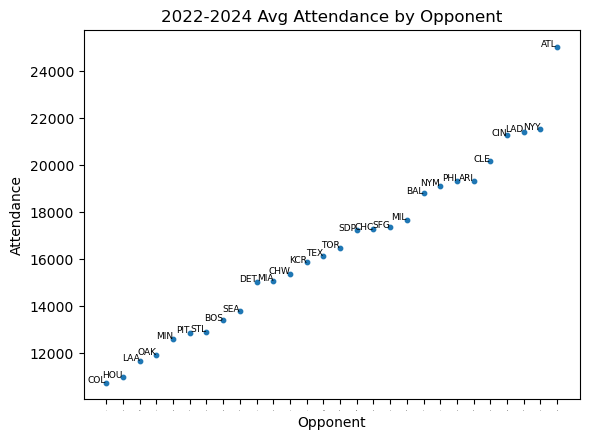

In [70]:
#Sorted scatterplot of Attendance per Opponent
opp_x = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'ab']
opp_total = [opp_ARI_mean, opp_ATL_mean, opp_BAL_mean, opp_BOS_mean, opp_CHC_mean, opp_CHW_mean, opp_CIN_mean, opp_CLE_mean, opp_COL_mean, opp_DET_mean, opp_HOU_mean, opp_KCR_mean, opp_LAA_mean, opp_LAD_mean, opp_MIA_mean, opp_MIL_mean, opp_MIN_mean, opp_NYM_mean, opp_NYY_mean, opp_OAK_mean, opp_PHI_mean, opp_PIT_mean, opp_SDP_mean, opp_SEA_mean, opp_SFG_mean, opp_STL_mean, opp_TEX_mean, opp_TOR_mean, opp_WSN_mean]
opp_labels=['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR', 'WSN']
oppo_data = sorted(zip(opp_total, opp_x, opp_labels))
sorted_opp_total, sorted_opp_x, sorted_opp_labels = zip(*oppo_data)

plt.scatter(sorted_opp_x, sorted_opp_total, s=10)

for i in range(len(sorted_opp_x)):
    plt.text(sorted_opp_x[i], sorted_opp_total[i], sorted_opp_labels[i], fontsize=6.5, ha='right')

plt.xticks(fontsize=0.1)
plt.xlabel('Opponent')
plt.ylabel('Attendance')
plt.title('2022-2024 Avg Attendance by Opponent')

In [72]:
#Concatenating Rays_combined dfs into one df
Rays_combined_df = pd.concat(Rays_combined, ignore_index=True)

#Attendance by Winning Record
win_attend = math.floor(Rays_combined_df[Rays_combined_df['W'] > Rays_combined_df['L']]['Attendance'].mean())
print("The average attendance from 2022-2024 when the Rays have a winning record is: ", win_attend)

#Attendance by Losing Record
lose_attend = math.floor(Rays_combined_df[Rays_combined_df['W'] < Rays_combined_df['L']]['Attendance'].mean())
print("The average attendance from 2022-2024 when the Rays have a losing record is: ", lose_attend)

# Ensure Rays_combined is a list of DataFrames
if all(isinstance(df, pd.DataFrame) for df in Rays_combined):
    # Concatenate the list of DataFrames into a single DataFrame
    df = pd.concat(Rays_combined, ignore_index=True)
else:
    raise TypeError("Rays_combined must be a list of DataFrames")

The average attendance from 2022-2024 when the Rays have a winning record is:  15868
The average attendance from 2022-2024 when the Rays have a losing record is:  16756


In [74]:
#Prediction of Estimated Net Rev, Estimated Gate Receipts, and Estimated Rev per fan if Avg ticket price increases
#Creating new df to not corrupt Rays_rev
Tick_df = pd.DataFrame(Rays_rev)

#Define features and target variables
Tick_X = Tick_df[['Avg ticket price']]
Rev_y = Tick_df['Estimated Net Revenue']
Gate_y = Tick_df['Estimated Gate Receipts']
Revfan_y = Tick_df['Estimated Revenue per fan']

#Split the data into training and testing sets
Tick_X_train, Tick_X_test, Rev_y_train, Rev_y_test = train_test_split(Tick_X, Rev_y, test_size=0.2, random_state=42)
Tick_X_train, Tick_X_test, Gate_y_train, Gate_y_test = train_test_split(Tick_X, Gate_y, test_size=0.2, random_state=42)
Tick_X_train, Tick_X_test, Revfan_y_train, Revfan_y_test = train_test_split(Tick_X, Revfan_y, test_size=0.2, random_state=42)

#Create and train the model for each target variable
model_net_revenue = LinearRegression()
model_net_revenue.fit(Tick_X_train, Rev_y_train)

model_gate_receipts = LinearRegression()
model_gate_receipts.fit(Tick_X_train, Gate_y_train)

model_revenue_per_fan = LinearRegression()
model_revenue_per_fan.fit(Tick_X_train, Revfan_y_train)

#Perform significance test with statsmodels for each model
def sig_test(X_train, y_train):
    X_train_sm = sm.add_constant(X_train)  
    model = sm.OLS(y_train, X_train_sm).fit()
    return model.summary()

#Significance test for Estimated Net Revenue
print("Significance test for Estimated Net Revenue:")
print(sig_test(Tick_X_train, Rev_y_train))

#Significance test for Estimated Gate Receipts
print("\nSignificance test for Estimated Gate Receipts:")
print(sig_test(Tick_X_train, Gate_y_train))

#Significance test for Estimated Revenue per Fan
print("\nSignificance test for Estimated Revenue per Fan:")
print(sig_test(Tick_X_train, Revfan_y_train))
    
#Function to predict the impact of a change in ticket price on revenues
def predict_impact(new_ticket_price):
    new_data = pd.DataFrame({'Avg ticket price': [new_ticket_price]})
    
    pred_net_revenue = model_net_revenue.predict(new_data)
    pred_gate_receipts = model_gate_receipts.predict(new_data)
    pred_revenue_per_fan = model_revenue_per_fan.predict(new_data)
    
    return round(pred_net_revenue[0],2), round(pred_gate_receipts[0],2), round(pred_revenue_per_fan[0],2)

#Example: Predict the impact of changing the Avg ticket price to $29
new_ticket_price = 29
predicted_net_revenue, predicted_gate_receipts, predicted_revenue_per_fan = predict_impact(new_ticket_price)

print(f"Predicted Estimated Net Revenue based on $29 Avg Ticket price: {predicted_net_revenue}")
print(f"Predicted Estimated Gate Receipts based on $29 Avg Ticket price: {predicted_gate_receipts}")
print(f"Predicted Estimated Revenue per Fan based on $29 Avg Ticket price: {predicted_revenue_per_fan}")

#Example: Predict the impact of changing the Avg ticket price to $31
new_ticket_price = 31
predicted_net_revenue, predicted_gate_receipts, predicted_revenue_per_fan = predict_impact(new_ticket_price)

print("")
print(f"Predicted Estimated Net Revenue based on $31 Avg Ticket price: {predicted_net_revenue}")
print(f"Predicted Estimated Gate Receipts based on $31 Avg Ticket price: {predicted_gate_receipts}")
print(f"Predicted Estimated Revenue per Fan based on $31 Avg Ticket price: {predicted_revenue_per_fan}")

Significance test for Estimated Net Revenue:
                              OLS Regression Results                             
Dep. Variable:     Estimated Net Revenue   R-squared:                       0.864
Model:                               OLS   Adj. R-squared:                  0.797
Method:                    Least Squares   F-statistic:                     12.74
Date:                   Tue, 03 Dec 2024   Prob (F-statistic):             0.0703
Time:                           20:48:16   Log-Likelihood:                -70.029
No. Observations:                      4   AIC:                             144.1
Df Residuals:                          2   BIC:                             142.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

C:\Users\holse\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\holse\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\holse\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [76]:
dfs = [tv_rank_data, metro_data, income_data, dis2park_data,fortune1000_data]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['City'], how='inner'), dfs)
columns_to_normalize = ['TV market rank', 'Metro area population','Distance to closest MLB team (in driving miles)','Count of Fortune 1000 companies','2022 Per capita personal income (in dollars)']
scaler = MinMaxScaler()
final_df[columns_to_normalize] = scaler.fit_transform(final_df[columns_to_normalize])
#train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
#test_df[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])


In [78]:
# Merge dataframes for RFClassifier
test_df = final_df[final_df['City'].isin(['Charlotte','Nashville','Raleigh','Orlando','Montreal','Tampa-St. Petersburg'])] #test data
train_df = final_df[~final_df['City'].isin(['Charlotte','Nashville','Raleigh','Orlando','Montreal','Tampa-St. Petersburg'])] #train data
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True, drop=True)

Random Forest Models

In [83]:
#Model for Predicting if a location is a good site for a team
x_train = train_df.iloc[:,[1,3,7,9,10]] #
y_train = train_df.iloc[:,2] # 
x_test = test_df.iloc[:,[1,3,7,9,10]] #
y_test = test_df.iloc[:,2]
rnd_clf = RandomForestClassifier(n_estimators=100, class_weight= 'balanced', random_state=42, n_jobs =-1)
rnd_clf.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Predictions, Confidences for Classifier

In [86]:
preds = rnd_clf.predict(x_test)
preds_conf_all = rnd_clf.predict_proba(x_test)
preds_confidence = np.transpose(preds_conf_all.max(axis=1))
correct = []
for i in range(len(preds_confidence)):
  if preds[i] == y_test[i]:
    correct.append(1)
  else:
    correct.append(0)
df = (pd.DataFrame([preds, preds_confidence, correct])).transpose()
df = df.join(test_df[['City','Has_Team']])
#df = df.join(all_df_test['Team'])
print('Accuracy: ', accuracy_score(preds, y_test))
df.columns = ['Class','Confidence','Correct','City','Has_Team']
#df.columns = ['Class','Confidence','Correct','Team']
df

Accuracy:  0.6666666666666666


,Class,Confidence,Correct,City,Has_Team
0,1.0,0.69,0.0,Charlotte,0
1,0.0,0.71,1.0,Nashville,0
2,0.0,0.73,1.0,Raleigh,0
3,1.0,0.51,0.0,Orlando,0
4,1.0,0.61,1.0,Tampa-St. Petersburg,1
5,0.0,0.51,1.0,Montreal,0


Plotting

C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

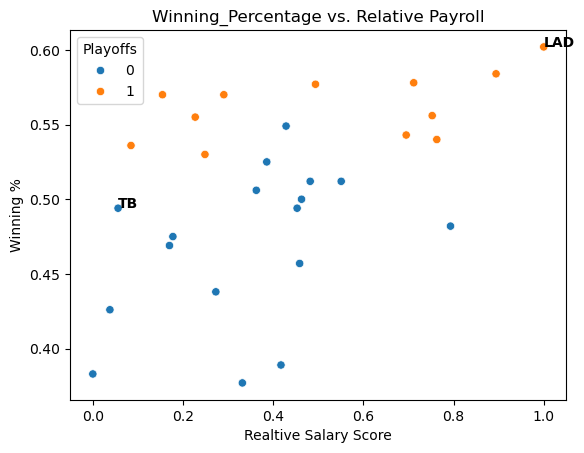

In [91]:
teams_i_want_to_vis = ['TB','LAD']
sns.scatterplot(data=all_df, x='Rel_Salary_Score', y='Winning_Percentage', hue='Playoffs')
plt.title('Winning_Percentage vs. Relative Payroll')
plt.xlabel('Realtive Salary Score')
plt.ylabel('Winning %')
for teams in teams_i_want_to_vis:
    temp_df = all_df[all_df['Team'] == teams]
    plt.text(
            temp_df["Rel_Salary_Score"],
            temp_df["Winning_Percentage"],
            s= teams,
            ha='left',
            weight='bold'
    )
plt.show()

C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

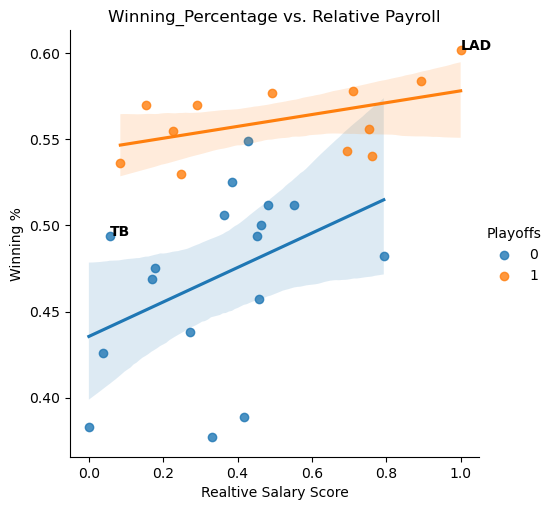

In [93]:
teams_i_want_to_vis = ['TB','LAD']
sns.lmplot(data=all_df, x='Rel_Salary_Score', y='Winning_Percentage', hue='Playoffs')
plt.title('Winning_Percentage vs. Relative Payroll')
plt.xlabel('Realtive Salary Score')
plt.ylabel('Winning %')
for teams in teams_i_want_to_vis:
    temp_df = all_df[all_df['Team'] == teams]
    plt.text(
            temp_df["Rel_Salary_Score"],
            temp_df["Winning_Percentage"],
            s= teams,
            ha='left',
            weight='bold'
    )
plt.show()

C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

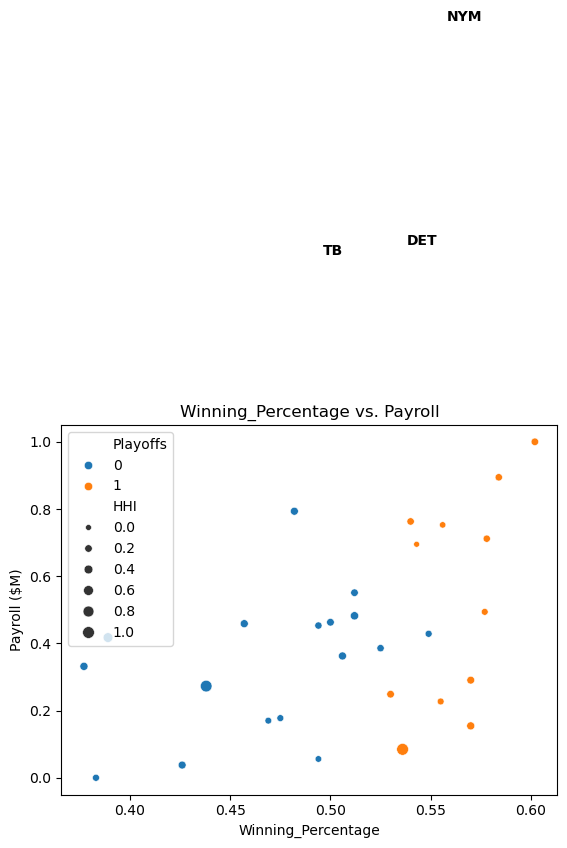

In [97]:
teams_i_want_to_vis = ['TB','DET','NYM']
sns.scatterplot(data=all_df, x='Winning_Percentage', y='Payroll', hue ='Playoffs', size = 'HHI')
plt.title('Winning_Percentage vs. Payroll')
plt.xlabel('Winning_Percentage')
plt.ylabel('Payroll ($M)')
for teams in teams_i_want_to_vis:
    temp_df = all_df[all_df['Team'] == teams]
    plt.text(
            temp_df["Winning_Percentage"]+ .002,
            temp_df["Payroll"]+1.5,
            s= teams,
            ha='left',
            weight='bold'
    )
plt.show()

C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\holse\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

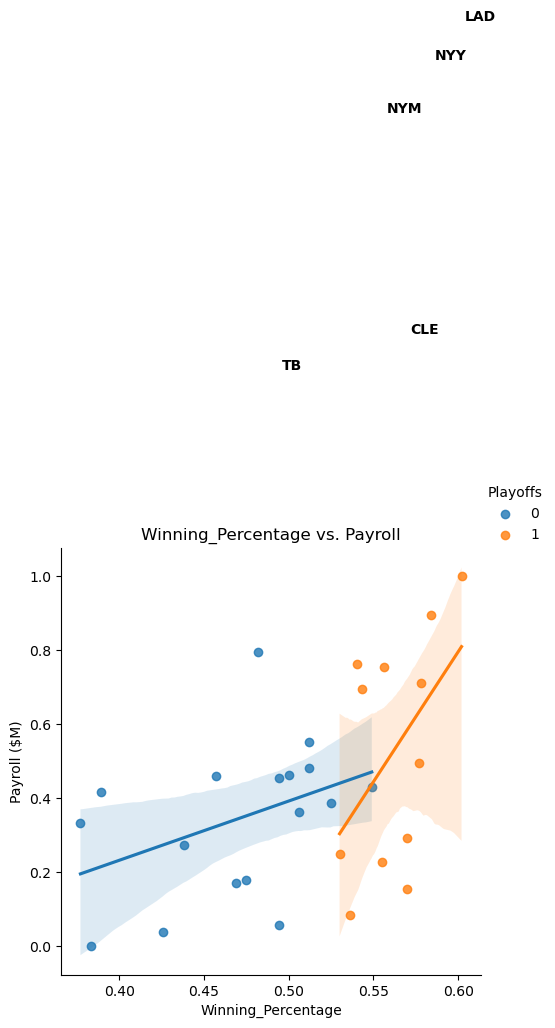

In [99]:
teams_i_want_to_vis = ['TB','NYY','NYM','CLE','LAD']
sns.lmplot(data=all_df, x='Winning_Percentage', y='Payroll', hue ='Playoffs')
plt.title('Winning_Percentage vs. Payroll')
plt.xlabel('Winning_Percentage')
plt.ylabel('Payroll ($M)')
for teams in teams_i_want_to_vis:
    temp_df = all_df[all_df['Team'] == teams]
    plt.text(
            temp_df["Winning_Percentage"]+ .002,
            temp_df["Payroll"]+1.5,
            s= teams,
            ha='left',
            weight='bold'
    )
plt.show()